1. Write a function that converts numbers among the bin, dec, and hex representations (bin<->dec<->hex)

In [1]:
a_bin = '0b10111'

def converting(a_bin):
    a_dec = int(a_bin, 2)
    a_hex = hex(a_dec)
    print('Decimal representation of', a_bin, ':', a_dec)
    print('Hexadecimal representation of', a_bin, ':', a_hex)
    
converting(a_bin)

Decimal representation of 0b10111 : 23
Hexadecimal representation of 0b10111 : 0x17


2\. Write a function that converts a 32 bit word into a single precision floating point (i.e. interprets the various bits as sign, mantissa and exponent) and check its validity.

In [2]:
fl = '11000000000100000000000000000000'

sign = int(fl[0])
exponent = int(fl[1 : 9], 2) - 127
mantissa_str = fl[9 : ]

power = -1
mantissa_int = 0

for i in mantissa_str:
    mantissa_int += (int(i) * pow(2, power))
    power -= 1

mantissa_int = mantissa_int + 1
a = pow(-1, sign) * mantissa_int * pow(2, exponent)
print("The representation is :", a)


The representation is : -2.25


3. Write a program to determine the underflow and overflow limits (within a factor of 2) for python on your computer. 

**Tip**: define two variables initialized to 1 and halve/double them for a sufficient amount of times to exceed the under/over-flow limits  

In [3]:
n = 1100
under = 1
under_lim = 1

for i in range(n):
    under = under / 2
    if under == 0:
        print("Underflow", under_lim)
        break
    under_lim = under
    print(i, "%2e"%under)



0 5.000000e-01
1 2.500000e-01
2 1.250000e-01
3 6.250000e-02
4 3.125000e-02
5 1.562500e-02
6 7.812500e-03
7 3.906250e-03
8 1.953125e-03
9 9.765625e-04
10 4.882812e-04
11 2.441406e-04
12 1.220703e-04
13 6.103516e-05
14 3.051758e-05
15 1.525879e-05
16 7.629395e-06
17 3.814697e-06
18 1.907349e-06
19 9.536743e-07
20 4.768372e-07
21 2.384186e-07
22 1.192093e-07
23 5.960464e-08
24 2.980232e-08
25 1.490116e-08
26 7.450581e-09
27 3.725290e-09
28 1.862645e-09
29 9.313226e-10
30 4.656613e-10
31 2.328306e-10
32 1.164153e-10
33 5.820766e-11
34 2.910383e-11
35 1.455192e-11
36 7.275958e-12
37 3.637979e-12
38 1.818989e-12
39 9.094947e-13
40 4.547474e-13
41 2.273737e-13
42 1.136868e-13
43 5.684342e-14
44 2.842171e-14
45 1.421085e-14
46 7.105427e-15
47 3.552714e-15
48 1.776357e-15
49 8.881784e-16
50 4.440892e-16
51 2.220446e-16
52 1.110223e-16
53 5.551115e-17
54 2.775558e-17
55 1.387779e-17
56 6.938894e-18
57 3.469447e-18
58 1.734723e-18
59 8.673617e-19
60 4.336809e-19
61 2.168404e-19
62 1.084202e-19
63

In [4]:
n = 1100
over = 1
over_lim = 1
        
for i in range(n):
    over = over * 2
    try:
        print(i, "%2e"%over)
        over_lim = over
    except OverflowError:
        print("Overflow", over_lim)
        break

0 2.000000e+00
1 4.000000e+00
2 8.000000e+00
3 1.600000e+01
4 3.200000e+01
5 6.400000e+01
6 1.280000e+02
7 2.560000e+02
8 5.120000e+02
9 1.024000e+03
10 2.048000e+03
11 4.096000e+03
12 8.192000e+03
13 1.638400e+04
14 3.276800e+04
15 6.553600e+04
16 1.310720e+05
17 2.621440e+05
18 5.242880e+05
19 1.048576e+06
20 2.097152e+06
21 4.194304e+06
22 8.388608e+06
23 1.677722e+07
24 3.355443e+07
25 6.710886e+07
26 1.342177e+08
27 2.684355e+08
28 5.368709e+08
29 1.073742e+09
30 2.147484e+09
31 4.294967e+09
32 8.589935e+09
33 1.717987e+10
34 3.435974e+10
35 6.871948e+10
36 1.374390e+11
37 2.748779e+11
38 5.497558e+11
39 1.099512e+12
40 2.199023e+12
41 4.398047e+12
42 8.796093e+12
43 1.759219e+13
44 3.518437e+13
45 7.036874e+13
46 1.407375e+14
47 2.814750e+14
48 5.629500e+14
49 1.125900e+15
50 2.251800e+15
51 4.503600e+15
52 9.007199e+15
53 1.801440e+16
54 3.602880e+16
55 7.205759e+16
56 1.441152e+17
57 2.882304e+17
58 5.764608e+17
59 1.152922e+18
60 2.305843e+18
61 4.611686e+18
62 9.223372e+18
63

4. Write a program to determine the machine precision

**Tip**: define a new variable by adding an increasingly smaller value (in the same way as the previous problem) and check when the addition starts to have no effect on the number

In [5]:
a, b = 1.0, 0.1

for i in range(20):
    print(i, a + b)
    b = b * 0.1

    

0 1.1
1 1.01
2 1.001
3 1.0001
4 1.00001
5 1.000001
6 1.0000001
7 1.00000001
8 1.000000001
9 1.0000000001
10 1.00000000001
11 1.000000000001
12 1.0000000000001
13 1.00000000000001
14 1.000000000000001
15 1.0
16 1.0
17 1.0
18 1.0
19 1.0


5\. Write a function that takes in input three parameters $a$, $b$ and $c$ and prints out the two solutions to the quadratic equation $ax^2+bx+c=0$ using the standard formula:
$$
x=\frac{-b\pm\sqrt{b^2-4ac}}{2a}
$$

(a) use the program to compute the solution for $a=0.001$, $b=1000$ and $c=0.001$

(b) re-express the standard solution formula by multiplying the numerator and the denominator by $-b\mp\sqrt{b^2-4ac}$ and again find the solution for $a=0.001$, $b=1000$ and $c=0.001$. How does it compare with what has been previously obtained, and why?

(c) write a function that computes the roots of a quadratic equation accurately in all cases

In [6]:
a, b, c = 0.001, 1000, 0.001

def x(a, b, c):
    x1 = (-b + ((b*b - 4*a*c)**0.5))/(2*a)
    x2 = (-b - ((b*b - 4*a*c)**0.5))/(2*a)
    print(x1)
    print(x2)
    
x(a, b, c)

def x_re(a, b, c):
    x1 = ((-b + ((b*b - 4*a*c)**0.5))*(-b + ((b*b - 4*a*c)**0.5)))/((2*a)*(-b + ((b*b - 4*a*c)**0.5)))
    x2 = ((-b - ((b*b - 4*a*c)**0.5))*(-b - ((b*b - 4*a*c)**0.5)))/((2*a)*(-b - ((b*b - 4*a*c)**0.5)))
    print(x1)
    print(x2)
    
x_re(a, b, c)

#def x_all(a, b, c):
#x_all(a, b, c)

-9.999894245993346e-07
-999999.999999
-9.999894245993346e-07
-999999.999999


2*x - 1
The derivative calculated using the derivative definition 1.01000000000000
The derivative calculated analytically 1.0
0.0001 1.00009999999989
1e-06 1.00000099991773
1e-08 1.00000000392253
1e-10 1.00000008284037
1e-12 1.00008890058334
1e-14 0.999200722162651


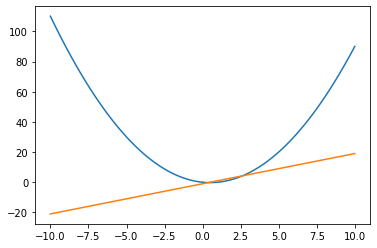

In [7]:
from sympy import limit, Symbol, diff
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import derivative

dl = 10**(-2)
x = Symbol('x') 
x0 = 1.0

def f(x):
    return x*(x-1)

def d(x):
    return derivative(f,x)

print(diff(f(x),x))

y = np.linspace(-10, 10, 100)
plt.plot(y, f(y))
plt.plot(y, d(y))

def lim(dl):
    return (f(x0 + dl) - f(x0))/dl; 

print("The derivative calculated using the derivative definition", limit(lim(dl), x0, 0))
print("The derivative calculated analytically", d(x0))

dl_l = [10**(-x) for x in range(4, 15) if x % 2 == 0]
for dl in dl_l:
    print(dl, limit(lim(dl), x0, 0))
    

7\. Consider the integral of the semicircle of radius 1:
$$
I=\int_{-1}^{1} \sqrt(1-x^2) {\rm d}x
$$
which is known to be $I=\frac{\pi}{2}=1.57079632679...$.

Alternatively we can use the Riemann definition of the integral:
$$
I=\lim_{N\to\infty} \sum_{k=1}^{N} h y_k 
$$

with $h=2/N$ the width of each of the $N$ slices the domain is divided into and where
$y_k$ is the value of the function at the $k-$th slice.

(a) Write a program to compute the integral with $N=100$. How does the result compare to the true value?

(b) How much can $N$ be increased if the computation needs to be run in less than a second? What is the gain in running it for 1 minute? 


In [8]:
from sympy import limit, Symbol, Sum, oo

n = 100
h = 2/n

def y(k):
    return (1 - x(k)*x(k))**0.5

def x(k):
    return -1 + h*k

k = Symbol('k') 
f = Sum(h*y(k), (k, 1, n))

print(limit(f.doit(), k, oo)) 
#The result is similar but not exactly the same. Only the first number after dot is the same


1.56913425554925


In [9]:
from sympy import limit, Symbol, Sum, oo
import time

n = 1000
h = 2/n

def y(k):
    return (1 - x(k)*x(k))**0.5

def x(k):
    return -1 + h*k

k = Symbol('k') 
f = Sum(h*y(k), (k, 1, n))

start = time.time()
print(limit(f.doit(), k, oo)) 
end = time.time()
print(end - start)
#N can be increased up to 1000. In this case we have 4 of the same numbers

1.57074373850107
1.003091812133789


In [10]:
from sympy import limit, Symbol, Sum, oo
import time

n = 65000
h = 2/n

def y(k):
    return (1 - x(k)*x(k))**0.5

def x(k):
    return -1 + h*k

k = Symbol('k') 
f = Sum(h*y(k), (k, 1, n))

start = time.time()
print(limit(f.doit(), k, oo)) 
end = time.time()
print(end - start)
#If we increase N up to 65000, we have 6 of the same numbers

1.57079622643846
59.74090385437012
